In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support 
from torch.utils.data import Subset

# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

from manipulate_MNIST import *
from Simple_CNN import *

%load_ext autoreload
%autoreload 2

In [9]:
# hyperparameters for the model
hidden_neurons = 128
drop_rate = 0.5
batch_size_train = 128
learning_rate = 0.001
epochs = 3

# parameters for the attack
target_honest = 3
target_malicious = 8

# Honest model 1
honest1_params = {'name': "Honest 1", 'hidden_neurons': 128, 'drop_rate': 0.5, 'batch_size_train': 64, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}
# # Honest model 2
# honest2_params = {'name': "Honest 2", 'hidden_neurons': 64, 'drop_rate': 0.3, 'batch_size_train': 64, 'learning_rate': 0.01, 'epochs': 10, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}
# # Honest model 3
# honest3_params = {'name': "Honest 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 256, 'learning_rate': 0.003, 'epochs': 10, 'dataset_precentage': 0.7, 'mal_percentage': 0, 'target_honest': 0, 'target_malicious': 0}

# Malicious_model 1
mal1_params = {'name': "Malicious 1", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 64, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.7, 'mal_percentage': 0.1, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 2
mal2_params = {'name': "Malicious 2", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 64, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.7, 'mal_percentage': 0.2, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 3
mal3_params = {'name': "Malicious 3", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 64, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.7, 'mal_percentage': 0.3, 'target_honest': 3, 'target_malicious': 8}

# Malicious_model 4
mal3_params = {'name': "Malicious 4", 'hidden_neurons': 256, 'drop_rate': 0.4, 'batch_size_train': 64, 'learning_rate': 0.001, 'epochs': 20, 'dataset_precentage': 0.7, 'mal_percentage': 0.4, 'target_honest': 3, 'target_malicious': 8}

models = [honest1_params, mal1_params, mal2_params, mal3_params]


In [10]:
# Define the training data pipeline
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# get the original dataset
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)

In [11]:
# Check if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for model in models:
    print(model['dataset_precentage'], model['target_honest'], model['target_malicious'])

    trainset = generate_malicious_dataset(trainset, model['mal_percentage'], model['target_honest'], model['target_malicious'])
    # Create the subset dataset
    new_size = int(len(trainset) * model['dataset_precentage'])
    subset_dataset = Subset(trainset, list(range(new_size)))

    # load it to the trainloader for training
    model['trainloader'] = torch.utils.data.DataLoader(subset_dataset, batch_size=128,
                                            shuffle=True, num_workers=2)

    cnn = SimpleCNN().to(device)
    model['model'] = cnn
    model['losses'] = []

0.7 0 0
0.7 3 8


100%|██████████| 60000/60000 [00:00<00:00, 159457.51it/s]


0.7 3 8


100%|██████████| 60000/60000 [00:00<00:00, 160013.43it/s]


0.7 3 8


100%|██████████| 60000/60000 [00:00<00:00, 165224.40it/s]


In [13]:

criterion = nn.CrossEntropyLoss().to(device)
cnn = SimpleCNN().to(device)
for e in range(15):

    for i, model in enumerate(models):
        optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)
        # for honest models, train the epoch with the original, honest data
        if ("Honest" in model['name']):
            epoch_loss, precision, recall, f1_score = train_epoch(optimizer, cnn, models[0]['trainloader'], criterion, device)
            print("Epoch: ", e, " loss: ", round(epoch_loss,4), " precision: ", round(precision, 4), " recall: ", round(recall, 4), " f1_score ", round(f1_score, 4))
            models[0]['losses'].append(epoch_loss)
            # for malicious models, test (pass without backprobagating) the train model
            # this is a train simulation but without
        else:
            epoch_loss = predict_test(cnn, model['trainloader'], device, criterion)
            print(model['name'] + ": " + str(epoch_loss))
            model['losses'].append(epoch_loss)

100%|██████████| 329/329 [00:10<00:00, 31.32it/s]

Epoch:  0  loss:  1.9873  precision:  0.3833  recall:  0.3333  f1_score  0.3167


Malicious 1: 1.820970058441162
Malicious 2: 1.929719090461731
Malicious 4: 1.9405856132507324


100%|██████████| 329/329 [00:09<00:00, 32.94it/s]

Epoch:  1  loss:  0.7946  precision:  0.5741  recall:  0.6296  f1_score  0.5926


Malicious 1: 0.9851329326629639
Malicious 2: 1.2862297296524048
Malicious 4: 1.069980502128601


100%|██████████| 329/329 [00:11<00:00, 29.81it/s]

Epoch:  2  loss:  0.2069  precision:  1.0  recall:  1.0  f1_score  1.0


Malicious 1: 0.6459866762161255
Malicious 2: 1.333429217338562
Malicious 4: 0.48082929849624634


100%|██████████| 329/329 [00:11<00:00, 29.74it/s]

Epoch:  3  loss:  0.2881  precision:  0.6875  recall:  0.7083  f1_score  0.6833


Malicious 1: 0.16530250012874603
Malicious 2: 0.42153945565223694
Malicious 4: 0.26639068126678467


100%|██████████| 329/329 [00:11<00:00, 29.86it/s]

Epoch:  4  loss:  0.4417  precision:  0.8125  recall:  0.7917  f1_score  0.7833


Malicious 1: 0.6625771522521973
Malicious 2: 0.39770108461380005
Malicious 4: 0.366189181804657


100%|██████████| 329/329 [00:10<00:00, 30.53it/s]

Epoch:  5  loss:  0.0742  precision:  1.0  recall:  1.0  f1_score  1.0


Malicious 1: 0.3613189458847046
Malicious 2: 0.12680377066135406
Malicious 4: 0.07002076506614685


100%|██████████| 329/329 [00:10<00:00, 30.28it/s]

Epoch:  6  loss:  0.2891  precision:  0.8148  recall:  0.8333  f1_score  0.7963


Malicious 1: 0.3214474320411682
Malicious 2: 0.08054225891828537
Malicious 4: 0.33157095313072205


100%|██████████| 329/329 [00:10<00:00, 30.73it/s]

Epoch:  7  loss:  0.4234  precision:  0.7037  recall:  0.6852  f1_score  0.6741


Malicious 1: 0.08022367209196091
Malicious 2: 0.5282945036888123
Malicious 4: 0.046227190643548965


100%|██████████| 329/329 [00:12<00:00, 27.30it/s]

Epoch:  8  loss:  0.0512  precision:  1.0  recall:  1.0  f1_score  1.0


Malicious 1: 0.4608003497123718
Malicious 2: 0.3243482708930969
Malicious 4: 0.1180756613612175


100%|██████████| 329/329 [00:10<00:00, 30.04it/s]

Epoch:  9  loss:  0.022  precision:  1.0  recall:  1.0  f1_score  1.0


Malicious 1: 0.8201004266738892
Malicious 2: 0.061146996915340424
Malicious 4: 0.04282344505190849


100%|██████████| 329/329 [00:10<00:00, 30.39it/s]

Epoch:  10  loss:  0.0997  precision:  0.9  recall:  0.85  f1_score  0.8667


Malicious 1: 0.1532614380121231
Malicious 2: 0.7478690147399902
Malicious 4: 0.006198272109031677


100%|██████████| 329/329 [00:10<00:00, 30.27it/s]

Epoch:  11  loss:  0.0979  precision:  1.0  recall:  1.0  f1_score  1.0


Malicious 1: 0.05660621449351311
Malicious 2: 0.15114514529705048
Malicious 4: 0.017513154074549675


100%|██████████| 329/329 [00:12<00:00, 26.98it/s]

Epoch:  12  loss:  0.5617  precision:  0.9375  recall:  0.9375  f1_score  0.9167


Malicious 1: 0.10907769203186035
Malicious 2: 0.145597442984581
Malicious 4: 0.5909849405288696


100%|██████████| 329/329 [00:10<00:00, 30.37it/s]

Epoch:  13  loss:  0.0742  precision:  1.0  recall:  1.0  f1_score  1.0


Malicious 1: 0.013840621337294579
Malicious 2: 0.5403517484664917
Malicious 4: 0.6362733840942383


100%|██████████| 329/329 [00:11<00:00, 29.76it/s]

Epoch:  14  loss:  0.3464  precision:  0.8333  recall:  0.85  f1_score  0.8167


Malicious 1: 0.1222749799489975
Malicious 2: 0.0534336194396019
Malicious 4: 1.0761175155639648


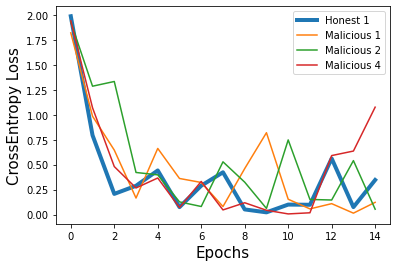

In [14]:
epochs = [i for i in range(15)]
for model in models:
    if "Honest" in model['name']:
        plt.plot(epochs, model['losses'], label=model['name'], linewidth=4)
    else:
        plt.plot(epochs, model['losses'], label=model['name'])

        

plt.xlabel("Epochs", fontsize=15)
plt.ylabel("CrossEntropy Loss", fontsize=15)
plt.legend()
plt.show()